In [26]:
!git add R

  master
* rakeshw_final


In [1]:
!pip install pytorch-lightning

     |████████████████████████████████| 839kB 19.8MB/s 
     |████████████████████████████████| 276kB 46.1MB/s 
     |████████████████████████████████| 112kB 50.6MB/s 
     |████████████████████████████████| 829kB 56.1MB/s 
     |████████████████████████████████| 184kB 53.1MB/s 
     |████████████████████████████████| 1.3MB 53.1MB/s 
     |████████████████████████████████| 296kB 50.8MB/s 
     |████████████████████████████████| 143kB 54.2MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44620 sha256=bb683c59498d07ae897f2bf1587a6d0eab081c0e6abc5876530ac7c3dc53f4df
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=aa80bdf7aad0540f03b87e6ca9c4c21cd40b7b97b58910a0f11cd893db963ca5
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built PyYAM

In [2]:
cd /content/drive/MyDrive/w207/blackboxes/utils/

/content/drive/MyDrive/w207/blackboxes/utils


In [3]:
#Set the utils path to point to the utils directory locally
UTILS_PATH = "utils/"

import os, sys
sys.path.append(UTILS_PATH)
from load_models import LoadTrainModels
from predict_models import PredictModels
from transform_data import TransformData
import imp
import pickle
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
import pytorch_lightning as pl

In [4]:
# https://niko-gamulin.medium.com/resnet-implementation-with-pytorch-from-scratch-23cf3047cb93
# Pytorch Lightning Tutorials to build networks : https://www.youtube.com/watch?v=DbESHcCoWbM&list=PLaMu-SDt_RB5NUm67hU2pdE75j6KaIOv2&index=3

### 
# This is a basic ResNet-18 building-block. Contains 2 Conv-layers and a residual-identity
# downsample layer.
###
class Block(pl.LightningModule):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        super(Block, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

        self.identity_downsample = identity_downsample

        # Building block's main-structure. Input of this block is bypassed and added to its output.
        self.block_main = nn.Sequential(
            self.conv1,
            self.bn,
            self.relu,
            self.conv2,
            self.bn,
            self.relu
        )

    def forward(self, x):
        identity = x
        x = self.block_main(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        # add identity to output of block before activation-function.
        x += identity
        x = self.relu(x)
        return x

In [18]:
class ResNet(pl.LightningModule):
    def __init__(self, data_file, num_classes):
        super(ResNet, self).__init__()
        self.data_file = data_file
        
        # Input Layer
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(in_channels=64, out_channels=64, stride=1)
        self.layer2 = self.make_layers(in_channels=64, out_channels=128, stride=2)
        self.layer3 = self.make_layers(in_channels=128, out_channels=256, stride=2)
        self.layer4 = self.make_layers(in_channels=256, out_channels=512, stride=2)

        # Output Layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

        # Loss Function
        self.loss = nn.CrossEntropyLoss()

        # Define the model structure
        self.model = nn.Sequential(
            # first Conv-layer
            self.conv1,
            self.bn,
            self.relu,
            self.maxpool,

            # residue-blocks
            self.layer1,
            self.layer2,
            self.layer3,
            self.layer4,
        )

    def forward(self, x):
        x = self.model(x)

        # Output Layers
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, in_channels, out_channels, stride):
        layers = []

        ### Residual path for each Block-layer
        identity_downsample = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(out_channels))
        
        layers.append(Block(in_channels, out_channels, identity_downsample, stride))
        layers.append(Block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def configure_optimizers(self):
        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        return self.optimizer

    def training_step(self, batch, batch_index):
        print("======================_______________")
        print(type(batch))
        print(batch.shape)
        X, y = batch

        b_size = X.size(0)
        x = x.view(b_size, -1)

        # Run 
        logits = self(x)

        # objective-function (loss) calculation
        J = self.loss(logits, y)
        
        # PTLightning automatically does these steps:
        # 1. zero_grad() # settings gradients to zero before each backpropogation
        # 2. J.backward() # backpropogation of loss
        # 3. optimizer.step() # stochastic gradient descent takes one step in the right direction of lowered loss.
        # 4. Takes care of what devices are available and where data needs to be pushed to (CPU/GPU/TPU)

        # return the Loss data from the training-step
        # Loss is a reserved-word and a key indicating loss. The training steps returns loss as a dict.
        return {'loss', J}

    # load train-data here; there are multiple data-files and this loads all of them into loaders.
    def train_dataloader(self):
        #Adding a transform data object if I want to do any transformations in this file
        transformdata = TransformData()

        print("Opening file: ", self.data_file)

        with open(self.data_file, "rb") as data_file:
            train_data = pickle.load(data_file)
            train_data = train_data.drop(['level_0', 'check_sum', 'index'], axis=1,errors='ignore')
            print("Train Shape:", train_data.shape)

            model_filename = str(self.data_file).replace('.p', '').strip()
            print("Begin model and train:")
            model_name = "".join((model_filename,"_rakesh"))
            print("Model name:", model_name)
            
            #Optional transformations to run
            flipped = transformdata.FlipHorizontal(train_data)
            train_data = pd.concat([train_data,flipped])

            return DataLoader(train_data, batch_size=64, shuffle=True)

In [ ]:
# https://medium.com/diving-in-deep/facial-keypoints-detection-with-pytorch-86bac79141e4
class FaceKeypointsDataset(Dataset):
    '''Face Keypoints Dataset'''
    def __init__(self, dataframe, train=True, data_file):
        '''
        Args:
            dataframe (DataFrame): data in pandas dataframe format.
            train (Boolean) : True for train data with keypoints, default is True
            transform (callable, optional): Optional transform to be applied on 
            sample
        '''
        self.dataframe = dataframe
        self.train = train
        self.data_file = data_file
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = np.fromstring(self.dataframe.iloc[idx, -1], sep=' ')\
                .astype(np.float32).reshape(-1, IMG_SIZE)
        if self.train:
            keypoints = self.dataframe.iloc[idx, :-1].values.astype(np.float32)
        else:
            keypoints = None
        sample = {'image': image, 'keypoints': keypoints}
        sample = self.__tp_tensor(sample)
        return sample

    def __to_tensor(self, sample):
        '''Convert ndarrays in sample to Tensors.'''
        image, keypoints = sample['image'], sample['keypoints']
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.reshape(1, IMG_SIZE, IMG_SIZE)
        image = torch.from_numpy(image)
        if keypoints is not None:
            keypoints = torch.from_numpy(keypoints)
            return {'image': image, 'keypoints': keypoints}
        else:
            return {'image': image}

In [8]:
cd /content/drive/My Drive/w207/blackboxes

/content/drive/My Drive/w207/blackboxes


In [19]:
file_path = "cleantrain/"
files = os.listdir(file_path)
clean_file = "".join((file_path,files[0]))

model = ResNet(data_file=clean_file, num_classes=30)

trainer = pl.Trainer(progress_bar_refresh_rate=20, max_epochs=2)
trainer.fit(model)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:52: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

   | Name    | Type              | Params
-----------------------------------------------
0  | conv1   | Conv2d            | 3.2 K 
1  | bn      | BatchNorm2d       | 128   
2  | relu    | ReLU              | 0     
3  | maxpool | MaxPool2d         | 0     
4  | layer1  | Sequential        | 86.7 K
5  | layer2  | Sequential        | 263 K 
6  | layer3  | Sequential        | 1.1 M 
7  | layer4  | Sequential        | 4.2 M 
8  | avgpool | AdaptiveAvgPool2d | 0     
9  | fc      | Linear            | 4.1 K 
10 | loss    | CrossEntropyLoss  | 0     
11 | model   | Sequential        | 5.6 M 
-----------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total para

Opening file:  cleantrain/clean_o_outliers.p
Train Shape: (7020, 31)
Begin model and train:
Model name: cleantrain/clean_o_outliers_rakesh


KeyError: ignored

In [49]:
print("train_data with flipped:", train_data.shape)
print(train_data['image'].shape)
image_sample = train_data['image'].values[464].reshape(96, 96)

train_data with flipped: (9160, 31)
(9160,)


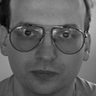

In [50]:
from google.colab.patches import cv2_imshow as cv2

cv2(image_sample)

In [22]:
loaders = []

file_path = "cleantrain/"
files = os.listdir(file_path)
clean_file = "".join((file_path,filename))

#For every version of a cleaned Train file in CleanTrain directory, create and save a model
for filename in files:
    # load model.train_dataloader(filename)

return loaders

Opening file:  clean_o_outliers.p
cleantrain/clean_o_outliers.p
Train Shape: (7020, 31)
Begin model and train:
Model name: clean_o_outliers_rakesh
